## Import libraries

In [1]:
import numpy as np 

import scipy as sp
import scipy.linalg as la   # la.eig()
import scipy.integrate
from scipy.integrate import odeint
from scipy.linalg import eigh  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif']=['SimHei']  
plt.rcParams['axes.unicode_minus']=False   

## One-meter beam is divided into ten parts

Text(0.5, 1.0, 'initial velocity')

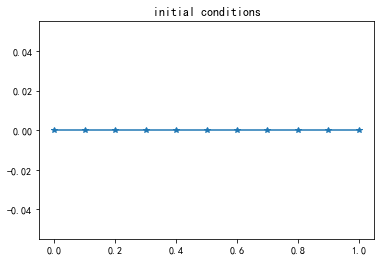

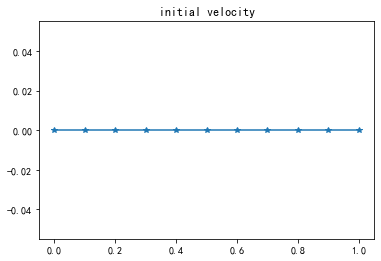

In [2]:
L = 1               # Beam length = 1 m
num_elems = 10  # divided into 10 parts
x = np.linspace(0,L,num_elems+1)   #x.shape =11

ini_shape= [ 0 for i in range(num_elems+1) ]
plt.figure()
plt.plot(x,ini_shape,marker='*')
plt.title("initial conditions")

plt.figure()
plt.plot(x,ini_shape,marker='*')
plt.title("initial velocity")

## Define material properties and element properties

In [3]:
l = x[1]-x[0]   # element length 
E = 210     # Young's modulus
u = 0.3         # Poisson's ratio
I = 6.51*10**-9 # Moment of inertia
Rho = 7860     # Material density
cc = 0.01        # Damping coefficient
q = 100          # Distribution force
t = np.linspace(0, 10, 101) # time series

k = (E*I/l**3)*np.array([ [12,6*l,-12,6*l],                     # element Stiffness matrix
                          [6*l,4*l**2,-6*l,2*l**2],
                          [-12,-6*l,12,-6*l],
                          [6*l,2*l**2,-6*l,4*l**2] ])
m = (Rho*l/420)* np.array([ [156,22*l,54,-13*l],                # element mass matrix
                            [22*l,4*l**2,13*l,-3*l**2],
                            [54,13*l,156,-22*l],
                            [-13*l,-3*l**2,-22*l,4*l**2] ])
c = m*(cc/Rho)                                                  # element damping matrix 
f = np.array([0.5*q*l,0,0.5*q*l,0])                             # element force matrix

## Assemble the overall matrix

In [4]:
def beam_matrx_add(num_elems):
    """
    input:  Number of element
    return: M_end : Overall mass matrix without fixed end constraints
            K_end : Overall stiffness matrix without fixed end constraints
            C_end : Overall damping matrix without fixed end constraints
            F_end : Overall force matrix without fixed end constraints
            F     : Overall force matrix
    """
    M = np.zeros((2*num_elems+2,2*num_elems+2))
    K = np.zeros((2*num_elems+2,2*num_elems+2))
    C = np.zeros((2*num_elems+2,2*num_elems+2))
    F = np.zeros(2*num_elems+2)
    
    for i in range(num_elems):
        M_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        K_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        C_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        F_temp = np.zeros(2*num_elems+2)
        M_temp[2*i:2*i+4, 2*i:2*i+4] = m    
        K_temp[2*i:2*i+4, 2*i:2*i+4] = k    # Slice assignment
        C_temp[2*i:2*i+4, 2*i:2*i+4] = c
        F_temp[2*i:2*i+4] = f
        M += M_temp
        K += K_temp
        C += C_temp
        F += F_temp
    M_end = M[2:,2:]    #Remove fixed end degrees of freedom: The first two rows and the first two columns
    K_end = K[2:,2:]
    C_end = C[2:,2:]
    F_end = F[2:]
    return M_end , K_end ,C_end ,F_end , F
    
M , K , C , F_end , F = beam_matrx_add( num_elems ) # K.shape =(20, 20)
M.shape

(20, 20)

## calculate the eigenvalue and the corresponding eigenvector

In [5]:
omega_2, fai = eigh(K,M)    # Return eigenvalues ​​and eigenvectors
omega = np.sqrt(omega_2)    # omega.shape = 20 # fai.shape = (20, 20)
print(omega)

[4.63703093e-05 2.90607138e-04 8.13888638e-04 1.59601040e-03
 2.64245200e-03 3.95869361e-03 5.55423923e-03 7.44114942e-03
 9.62131370e-03 1.19606809e-02 1.59191357e-02 1.92323214e-02
 2.33140453e-02 2.81384972e-02 3.38125517e-02 4.04400719e-02
 4.79960947e-02 5.60331562e-02 6.30995527e-02 7.89683487e-02]


## Plot: Draw the first three modes

Text(0.5, 1.0, 'Analytical solution in vibration mechanics ')

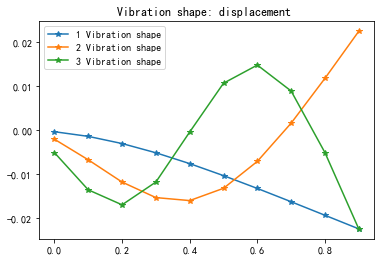

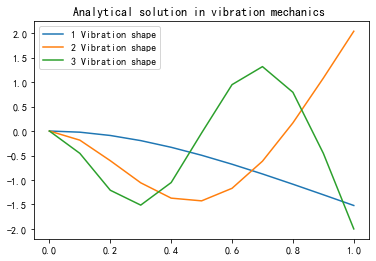

In [6]:
plt.plot(np.arange(0,1,1/num_elems),-fai[::2,0],label="1 Vibration shape",marker='*')
plt.plot(np.arange(0,1,1/num_elems),-fai[::2,1],label="2 Vibration shape",marker='*')
plt.plot(np.arange(0,1,1/num_elems), fai[::2,2],label="3 Vibration shape",marker='*')  
plt.legend()
plt.title(" Vibration shape: displacement  ")

plt.figure()    ### Exact solutions in vibration mechanics
def static(i,x):
    beta_i = (2*i-1)*np.pi / (2*L)
    kexi_i = - ( np.cos(beta_i*L)+np.cosh(beta_i*L) ) / ( np.sin(beta_i*L)+np.sinh(beta_i*L) )
    fai_i = np.cos(beta_i*x) - np.cosh(beta_i*x) + kexi_i*(np.sin(beta_i*x)-np.sinh(beta_i*x))
    return fai_i
for i in range(1,4):
    plt.plot(x,static(i,x),label="{} Vibration shape".format(i))
    plt.legend()
plt.title("Analytical solution in vibration mechanics ")

In [7]:
# plt.plot(np.linspace(0,1,num_elems), fai[1:22:2,0],label="1 Vibration shape",marker='*')
# plt.plot(np.linspace(0,1,num_elems),-fai[1:22:2,1],label="2 Vibration shape",marker='*')
# plt.plot(np.linspace(0,1,num_elems), fai[1:22:2,2],label="3 Vibration shape",marker='*')
# plt.legend()
# plt.title(" Vibration shape: angle ")

## Solve ordinary differential equations

In [8]:
result = np.zeros( ( 101 , len(omega) ) )

def diff(y,t):                                      # define ODE 
    F_i = fai[: ,i].T  @ F_end * x[ int(i/2) ]/L * np.sin(1.1*4.63703093*(10**-5)*t)
    yt, theta = y
    return theta , (F_i-K_i*yt-C_i*theta) / M_i     


for i in range( len(omega) ):           # Calculate the ODE corresponding to each eigenvalue
    M_i = (fai[:,i].T) @ M @ fai[:,i] 
    K_i = (fai[:,i].T) @ K @ fai[:,i] 
    C_i = (fai[:,i].T) @ C @ fai[:,i]
    # F_i = fai[: ,i].T  @ F_end *1    
    y0 = [0,0]                          # initial conditions
    sol = odeint(diff, y0, t)           # Call the odeint function to solve
    result[:,i] += sol[:,0]             # Put the result of each solution into the  "result" matrix
    
result.shape # =(101,20)

(101, 20)

## Superimpose to get the response of the original coordinates

In [9]:
x_result = np.zeros((20,101))   #  result of original coordinates
for i in range(len(omega)):
    x_result += fai[:,i].reshape(-1,1) @ result[:,i].reshape(1,-1) 
x_result.shape # =(20, 101)

(20, 101)

Text(0.5, 0.92, 'angle $\\theta$ change ')

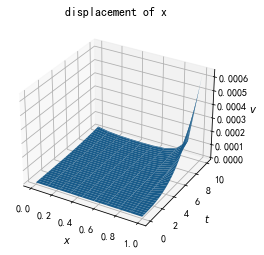

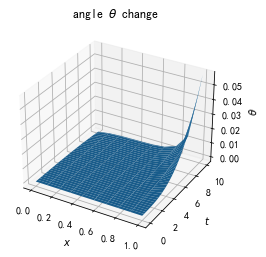

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result[::2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$v$')
ax.set_title('displacement of x')


fig1 = plt.figure()
ax1 = fig1.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax1.plot_surface(X,T,x_result[1:2*num_elems:2,::].T)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$t$')
ax1.set_zlabel(r'$\theta $')
ax1.set_title('angle 'r'$\theta$ change ')

Text(0.5, 1.0, 'displacement v at the midpoint')

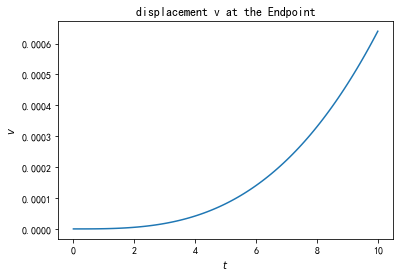

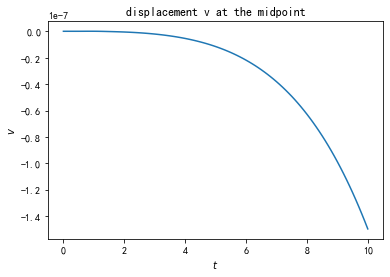

In [11]:
plt.plot( t,x_result[18,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the Endpoint')

plt.figure()
plt.plot( t,x_result[8,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the midpoint')

Text(0.5, 1.0, 'angle $\\theta$ change at the midpoint')

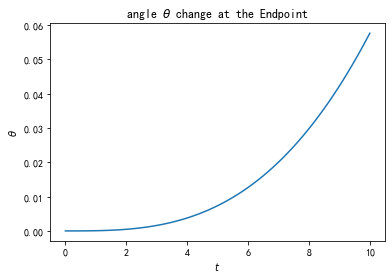

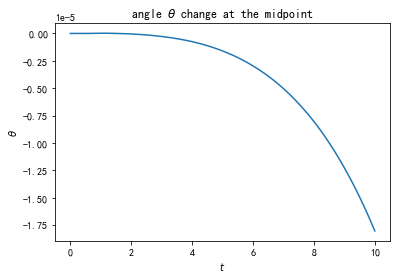

In [12]:
plt.plot( t,x_result[19,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the Endpoint')

plt.figure()
plt.plot( t,x_result[9,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the midpoint')

# only endpoint force

In [13]:
result = np.zeros(    ( 101,len(omega)  )     )
F_endpoint = np.array([0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 100,0])

def diff(y,t):                                      # define ODE 
    yt, theta = y
    return theta , (F_i-K_i*yt-C_i*theta) / M_i     

y00 = np.array( [0,0,0,0,       # 0 ICs matrix: u1 u1'  theta1 theta1'……
                 0,0,0,0,       # 1
                 0,0,0,0,       # 2
                 0,0,0,0,       # 3
                 0,0,0,0,       # 4
                 0,0,0,0,       # 5
                 0,0,0,0,       # 6
                 0,0,0,0,       # 7
                 0,0,0,0,       # 8
                 0,0,0,0,       # 9
                 0,0,0,0 ] )    # 10

for i in range( len(omega) ):           # Calculate the ODE corresponding to each eigenvalue
    M_i = (fai[:,i].T) @ M @ fai[:,i] 
    K_i = (fai[:,i].T) @ K @ fai[:,i] 
    C_i = (fai[:,i].T) @ C @ fai[:,i] 
    F_i = (fai[:,i].T) @ F_endpoint 
    y0 = [ y00[4+2*i],y00[4+2*i+1] ]    # initial conditions                      
    sol = odeint(diff, y0, t)           # Call the odeint function to solve
    result[:,i] += sol[:,0]             # Put the result of each solution into the  "result" matrix
print("result of Generalized Coordinates : result.shape   =",result.shape) # =(101,20)

x_result = np.zeros((20,101))   #  result of original coordinates
for i in range(len(omega)):
    x_result += fai[:,i].reshape(-1,1) @ result[:,i].reshape(1,-1) 
print("result  of  original  coordinates : x_result.shape =",x_result.shape) # =(20, 101)

result of Generalized Coordinates : result.shape   = (101, 20)
result  of  original  coordinates : x_result.shape = (20, 101)


Text(0.5, 0.92, 'angle $\\theta$ change ')

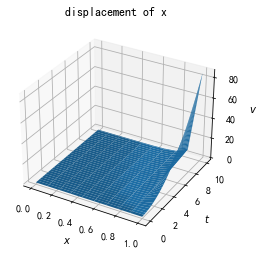

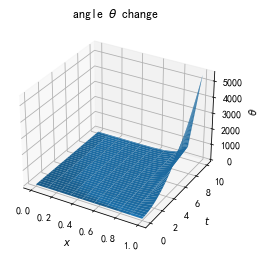

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result[::2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$v$')
ax.set_title('displacement of x')


fig1 = plt.figure()
ax = fig1.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result[1:2*num_elems:2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel(r'$\theta $')
ax.set_title('angle 'r'$\theta$ change ')

Text(0.5, 1.0, 'displacement v at the midpoint')

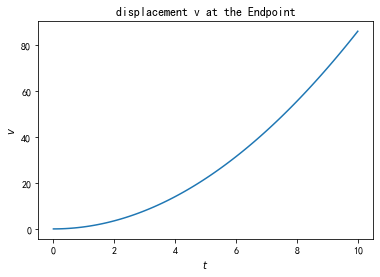

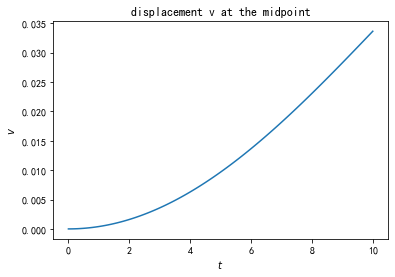

In [15]:
plt.figure()
plt.plot( t,x_result[18,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the Endpoint')

plt.figure()
plt.plot( t,x_result[8,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the midpoint')

Text(0.5, 1.0, 'angle $\\theta$ change at the midpoint')

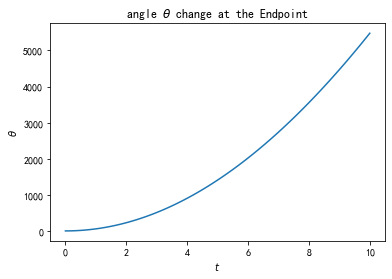

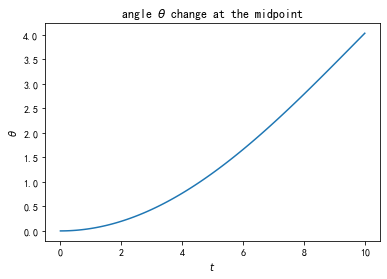

In [16]:
plt.figure()
plt.plot( t,x_result[19,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the Endpoint')
plt.figure()
plt.plot( t,x_result[9,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the midpoint')

# free vibration

result of Generalized Coordinates : result.shape = (101, 20)
result of original coordinates: x_result.shape =  (20, 101)


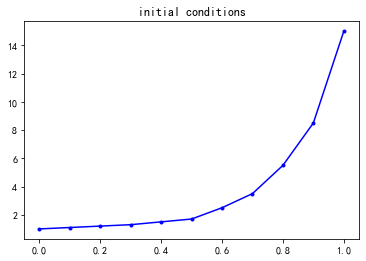

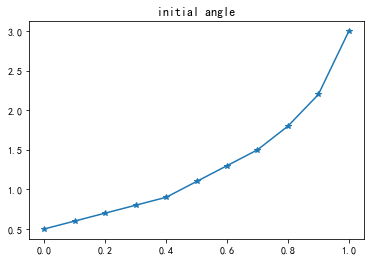

In [17]:
result = np.zeros(    ( 101,len(omega)  )     )
F_endpoint = np.array([0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0])

def diff(y,t):                                      # define ODE 
    yt, theta = y
    return theta , (F_i-K_i*yt-C_i*theta) / M_i     

y00 = np.array( [   [1,0,0.5,0],         # 0 ICs matrix: u1 u1'  theta1 theta1'……
                    [1.1,0,0.6,0],       # 1
                    [1.2,0,0.7,0],       # 2
                    [1.3,0,0.8,0],       # 3
                    [1.5,0,0.9,0],       # 4
                    [1.7,0,1.1,0],       # 5
                    [2.5,0,1.3,0],       # 6
                    [3.5,0,1.5,0],       # 7
                    [5.5,0,1.8,0],       # 8
                    [8.5,0,2.2,0],       # 9
                    [15,0,3,0]   ] )     # 10
plt.plot(x,y00[:,0],'-b',marker='.')
plt.title("initial conditions")
plt.figure()
plt.plot(x,y00[:,2],marker='*')
plt.title("initial angle")
y01=y00.reshape(1,-1)


for i in range( len(omega) ):           # Calculate the ODE corresponding to each eigenvalue
    M_i = (fai[:,i].T) @ M @ fai[:,i] 
    K_i = (fai[:,i].T) @ K @ fai[:,i] 
    C_i = (fai[:,i].T) @ C @ fai[:,i] 
    F_i = (fai[:,i].T) @ F_endpoint 
    
    y0 = [y01[0,(4+2*i)] ,y01[0,(4+2*i+1)] ]                          # initial conditions
    sol = odeint(diff, y0, t)           # Call the odeint function to solve
    result[:,i] += sol[:,0]             # Put the result of each solution into the  "result" matrix
    

print("result of Generalized Coordinates : result.shape =",result.shape) # =(101,20)


x_result = np.zeros((20,101))   #  result of original coordinates
for i in range(len(omega)):
    x_result += fai[:,i].reshape(-1,1) @ result[:,i].reshape(1,-1) 

print("result of original coordinates: x_result.shape = ",x_result.shape) # =(20, 101)

Text(0.5, 0.92, 'angle $\\theta$ change ')

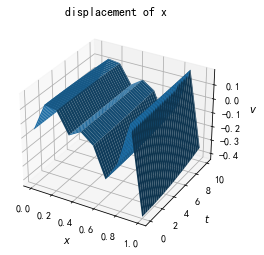

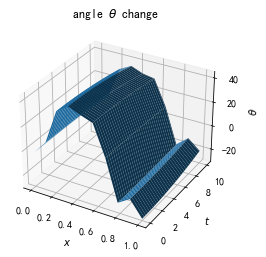

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result[::2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$v$')
ax.set_title('displacement of x')


fig1 = plt.figure()
ax = fig1.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result[1:2*num_elems:2,::].T)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel(r'$\theta $')
ax.set_title('angle 'r'$\theta$ change ')

Text(0.5, 1.0, 'displacement v at the midpoint')

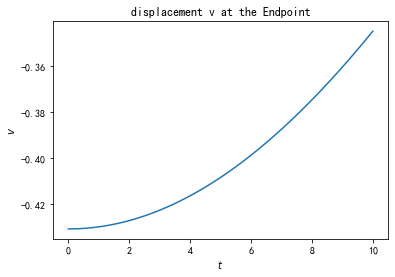

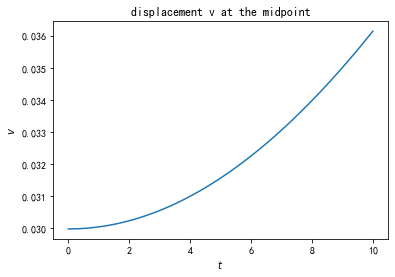

In [19]:
plt.figure()
plt.plot( t,x_result[18,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the Endpoint')

plt.figure()
plt.plot( t,x_result[8,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the midpoint')

Text(0.5, 1.0, 'angle $\\theta$ change at the midpoint')

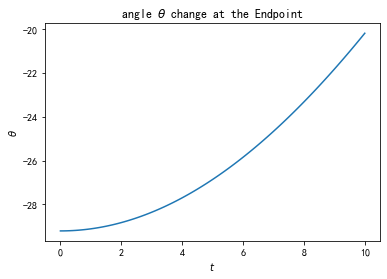

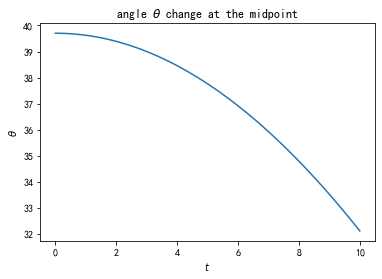

In [20]:
plt.figure()
plt.plot( t,x_result[19,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the Endpoint')
plt.figure()
plt.plot( t,x_result[9,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the midpoint')